## Defining the Convolutional Neural Network

In [1]:
# import the resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=28224, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=136, bias=True)
  (drop1): Dropout(p=0.4, inplace=False)
)


## Transforming the dataset 

To prepare for training, creating a transformed dataset of images and keypoints.

### Defining a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. F

Defining the data transform below, using a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224 x 224 px). **The CNN architecture I have used demands images to be 96 x 96, so have resized them accordingly**
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose( [Rescale(100) , RandomCrop(96) , Normalize() , ToTensor()] )

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [4]:
# creating the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterating through the transformed dataset and printing some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 96, 96]) torch.Size([68, 2])
1 torch.Size([1, 96, 96]) torch.Size([68, 2])
2 torch.Size([1, 96, 96]) torch.Size([68, 2])
3 torch.Size([1, 96, 96]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, PyTorch's DataLoader class can be used to load the training data in batches of whatever size as well as to shuffle the data for training the model. More can be read about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).


In [5]:
# load training data in batches
batch_size = 20

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

#### Loading in the test dataset

In [6]:
# loading in the test data, using the dataset class and applying the data_transforms defined above

# creating the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [8]:
# loading test data in batches
batch_size = 20

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Applying the model on a test sample

To test the model on a test sample of data, the following steps must be followed:
1. Extraction of the image and ground truth keypoints from a sample
2. Making sure the image is a FloatTensor, which the model expects.
3. Forward passing the image through the net to get the predicted, output keypoints.

This function tests how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# testing the model on a batch of test images

def net_sample_output():
    
    # iterating through the test dataset
    for i, sample in enumerate(test_loader):
        
        # getting sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # converting images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshaping to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

In [10]:
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# printing out the dimensions of the data : sanity check
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([20, 1, 96, 96])
torch.Size([20, 68, 2])
torch.Size([20, 68, 2])


## Visualizing the predicted keypoints

Once the model produces some predicted output keypoints, the points can be visualised in a way that's similar to how the data has been displayed before.

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plotting ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, is a helper function.  
`visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; assuming the transformations were applied while loading in the test data.

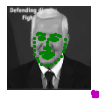

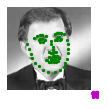

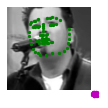

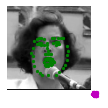

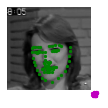

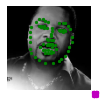

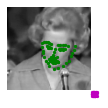

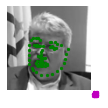

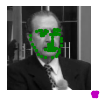

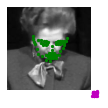

In [12]:
# visualizing the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transforming the image data
        image = test_images[i].data   # getting the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transposing to go from torch to numpy image

        # un-transforming the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undoing normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plotting ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # calling show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
#function invocation
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class;  
As the given problem is a regression problem, a loss function that is suited for the case is used, which directly compares a predicted value and target value.  
[PyTorch documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### Defining the loss and optimization

Next, defining how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## Defining the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr = 0.001)


## Training and Initial Observation

Next, training on batched training data from `train_loader` for a number of epochs. 

Hyperparameter tuning is done at this stage

In [14]:
def train_net(n_epochs):

    loss_list=[]
    # preparing the net for training
    net.train()
    for epoch in range(n_epochs):  # looping over the dataset multiple times
        running_loss = 0.0
        # training on batches of data, assuming train_loader is used
        for batch_i, data in enumerate(train_loader):
            
            # getting the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']
            
            # flattening pts
            key_pts = key_pts.view(key_pts.size(0), -1)
            
            # converting variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            
            # forwarding pass to get outputs
            output_pts = net(images)

            # calculating the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero-ing the existing weight gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # updating the weights
            optimizer.step()

            # printing loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # printing every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                loss_list.append(running_loss/1000)
                running_loss = 0.0

    print('Finished Training')
    plt.plot(range(len(loss_list)), loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Avg Loss')
    plt.show()

Epoch: 1, Batch: 10, Avg. Loss: 0.002050012446939945
Epoch: 1, Batch: 20, Avg. Loss: 0.0006064778044819832
Epoch: 1, Batch: 30, Avg. Loss: 0.00035830970853567123
Epoch: 1, Batch: 40, Avg. Loss: 0.0003102003559470177
Epoch: 1, Batch: 50, Avg. Loss: 0.00033237330242991446
Epoch: 1, Batch: 60, Avg. Loss: 0.000366170346736908
Epoch: 1, Batch: 70, Avg. Loss: 0.00034791816771030426
Epoch: 1, Batch: 80, Avg. Loss: 0.0002579844929277897
Epoch: 1, Batch: 90, Avg. Loss: 0.0002576685342937708
Epoch: 1, Batch: 100, Avg. Loss: 0.00022769235540181398
Epoch: 1, Batch: 110, Avg. Loss: 0.0002068635057657957
Epoch: 1, Batch: 120, Avg. Loss: 0.00023702874220907688
Epoch: 1, Batch: 130, Avg. Loss: 0.0002096374249085784
Epoch: 1, Batch: 140, Avg. Loss: 0.00019306537695229053
Epoch: 1, Batch: 150, Avg. Loss: 0.00022234470304101706
Epoch: 1, Batch: 160, Avg. Loss: 0.0002368200495839119
Epoch: 1, Batch: 170, Avg. Loss: 0.00020642757043242454
Epoch: 2, Batch: 10, Avg. Loss: 0.00036698183976113796
Epoch: 2, Bat

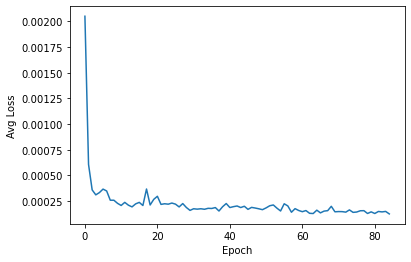

In [15]:
# train your network
n_epochs = 5 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

## Test data  

To test the model performance on previously unseen, test data.  
The trained model is run on the images to see what kind of keypoints are produced.

In [16]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([20, 1, 96, 96])
torch.Size([20, 68, 2])
torch.Size([20, 68, 2])


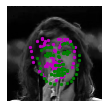

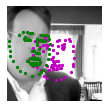

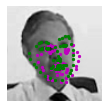

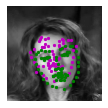

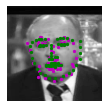

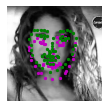

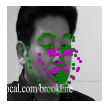

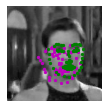

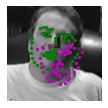

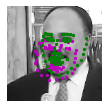

In [17]:
## visualizing test output
visualize_output(test_images, test_outputs, gt_pts)

Once a good model has been found, it is saved for further use later!

In [18]:
model_dir = 'saved_models/'
model_name = 'keypoints_model_2.pt'

# after training, saving the model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output.   However, CNNs learn to recognize a variety of spatial patterns and one can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image.  
This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

[[-0.01501145 -0.10819519 -0.11644706  0.14530618 -0.13161813]
 [ 0.02352959 -0.05431431 -0.05019252 -0.1895529  -0.0159348 ]
 [ 0.16410637  0.07383262 -0.1132412   0.1319203  -0.00302415]
 [-0.07131792 -0.08387599  0.03687014  0.01875169  0.11679332]
 [-0.12391466 -0.14369416 -0.1084858   0.11481763 -0.22391051]]
(5, 5)


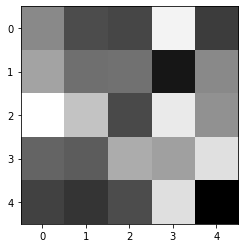

In [19]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**.  
So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image.  
These maps show the features that the different layers of the neural network learn to extract.  
For example, the filter below brings out the lines in an the image, and thus, it might be characterized as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>
